In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
print(df.shape)
df.head()

(1344, 4)


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Series ID,Year,Period,Value
0,CUUR0000SA0,1913,M02,0.0
1,CUUR0000SA0,1913,M03,0.0
2,CUUR0000SA0,1913,M04,0.0
3,CUUR0000SA0,1913,M05,-1.0
4,CUUR0000SA0,1913,M06,1.0


In [3]:
df.columns

Index(['Series ID', 'Year', 'Period', 'Value'], dtype='object')

In [4]:
df = df.drop(columns=['Series ID'])
print(df.shape)
df.head()

(1344, 3)


,Year,Period,Value
0,1913,M02,0.0
1,1913,M03,0.0
2,1913,M04,0.0
3,1913,M05,-1.0
4,1913,M06,1.0


In [5]:
df = df[df['Period'].str.startswith('M')]


In [6]:
# Create the "Date" column:
# - Year is taken directly from the 'Year' column
# - Month is extracted from the 'Period' column (e.g., 'M01' → '01')
# - Day is fixed as '01'
df['Date'] = df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01'
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Year,Period,Value,Date
0,1913,M02,0.0,1913-02-01
1,1913,M03,0.0,1913-03-01
2,1913,M04,0.0,1913-04-01
3,1913,M05,-1.0,1913-05-01
4,1913,M06,1.0,1913-06-01


In [7]:
df = df[['Date', 'Value']]  # Reorder columns
df.columns = ['timestamp', 'CPI']  # Rename columns for consistency
df.head()

,timestamp,CPI
0,1913-02-01,0.0
1,1913-03-01,0.0
2,1913-04-01,0.0
3,1913-05-01,-1.0
4,1913-06-01,1.0


In [8]:
df = df.set_index('timestamp')
df.head()

,CPI
timestamp,
1913-02-01,0.0
1913-03-01,0.0
1913-04-01,0.0
1913-05-01,-1.0
1913-06-01,1.0


## Exploratory Data Analysis

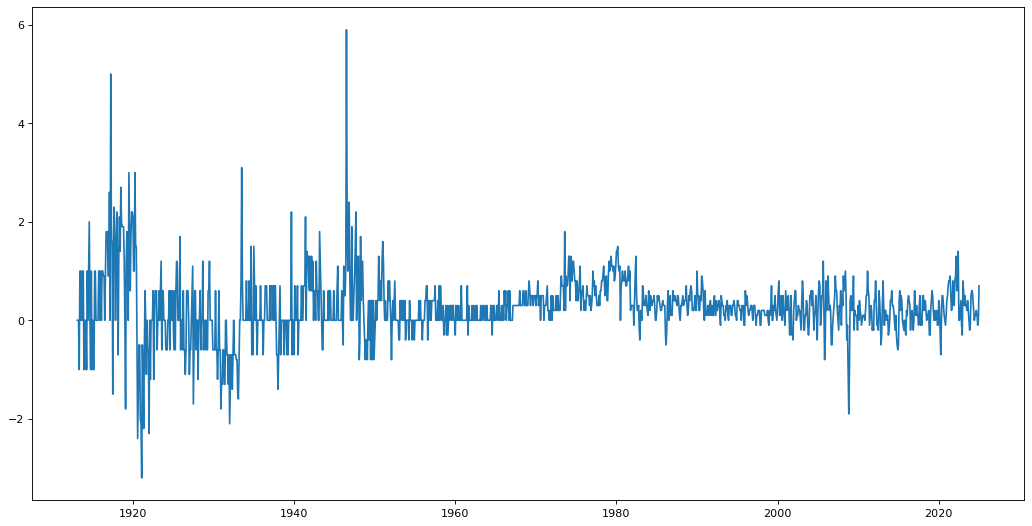

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

## CHECK OUTLIER

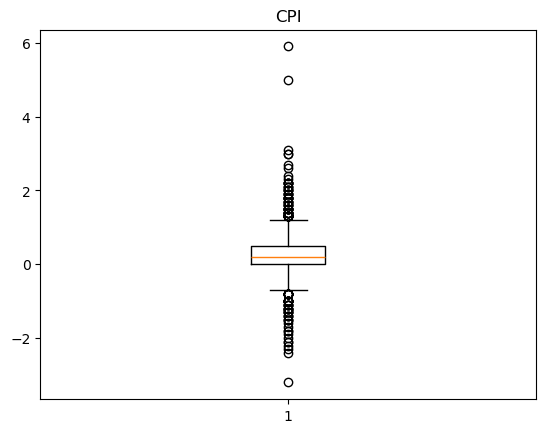

In [10]:
def box_plot(df,i):
  plt.boxplot(df.iloc[:,i])
  plt.title(df.columns.values.tolist()[i])
  plt.show()
box_plot(df,0)

In [11]:

q1 = np.percentile(df['CPI'],25)
q3 = np.percentile(df['CPI'],75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
column_name = 'CPI'
new_value = np.mean(df['CPI'])

df.loc[boolean_condition, column_name] = new_value
df.head()

,CPI
timestamp,
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,1.000000


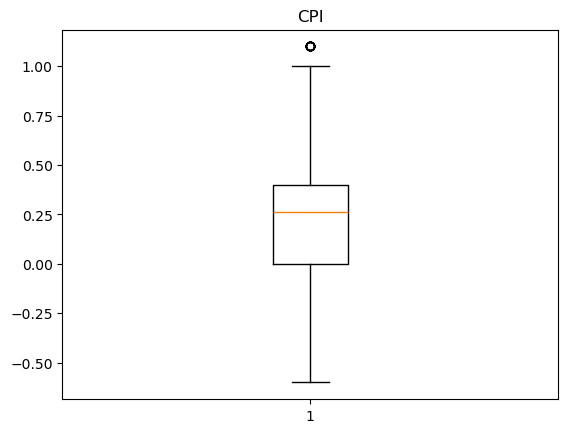

In [12]:

box_plot(df,0)

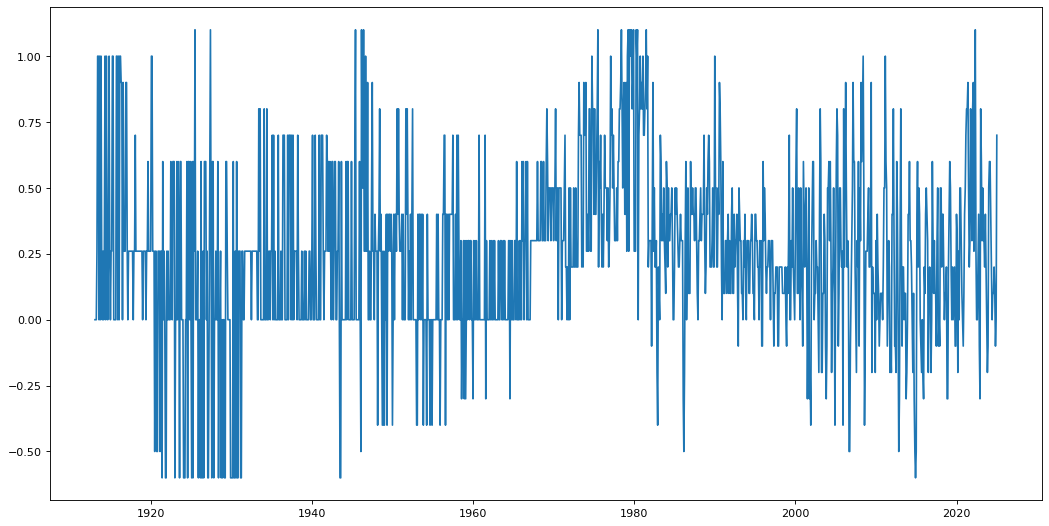

In [13]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

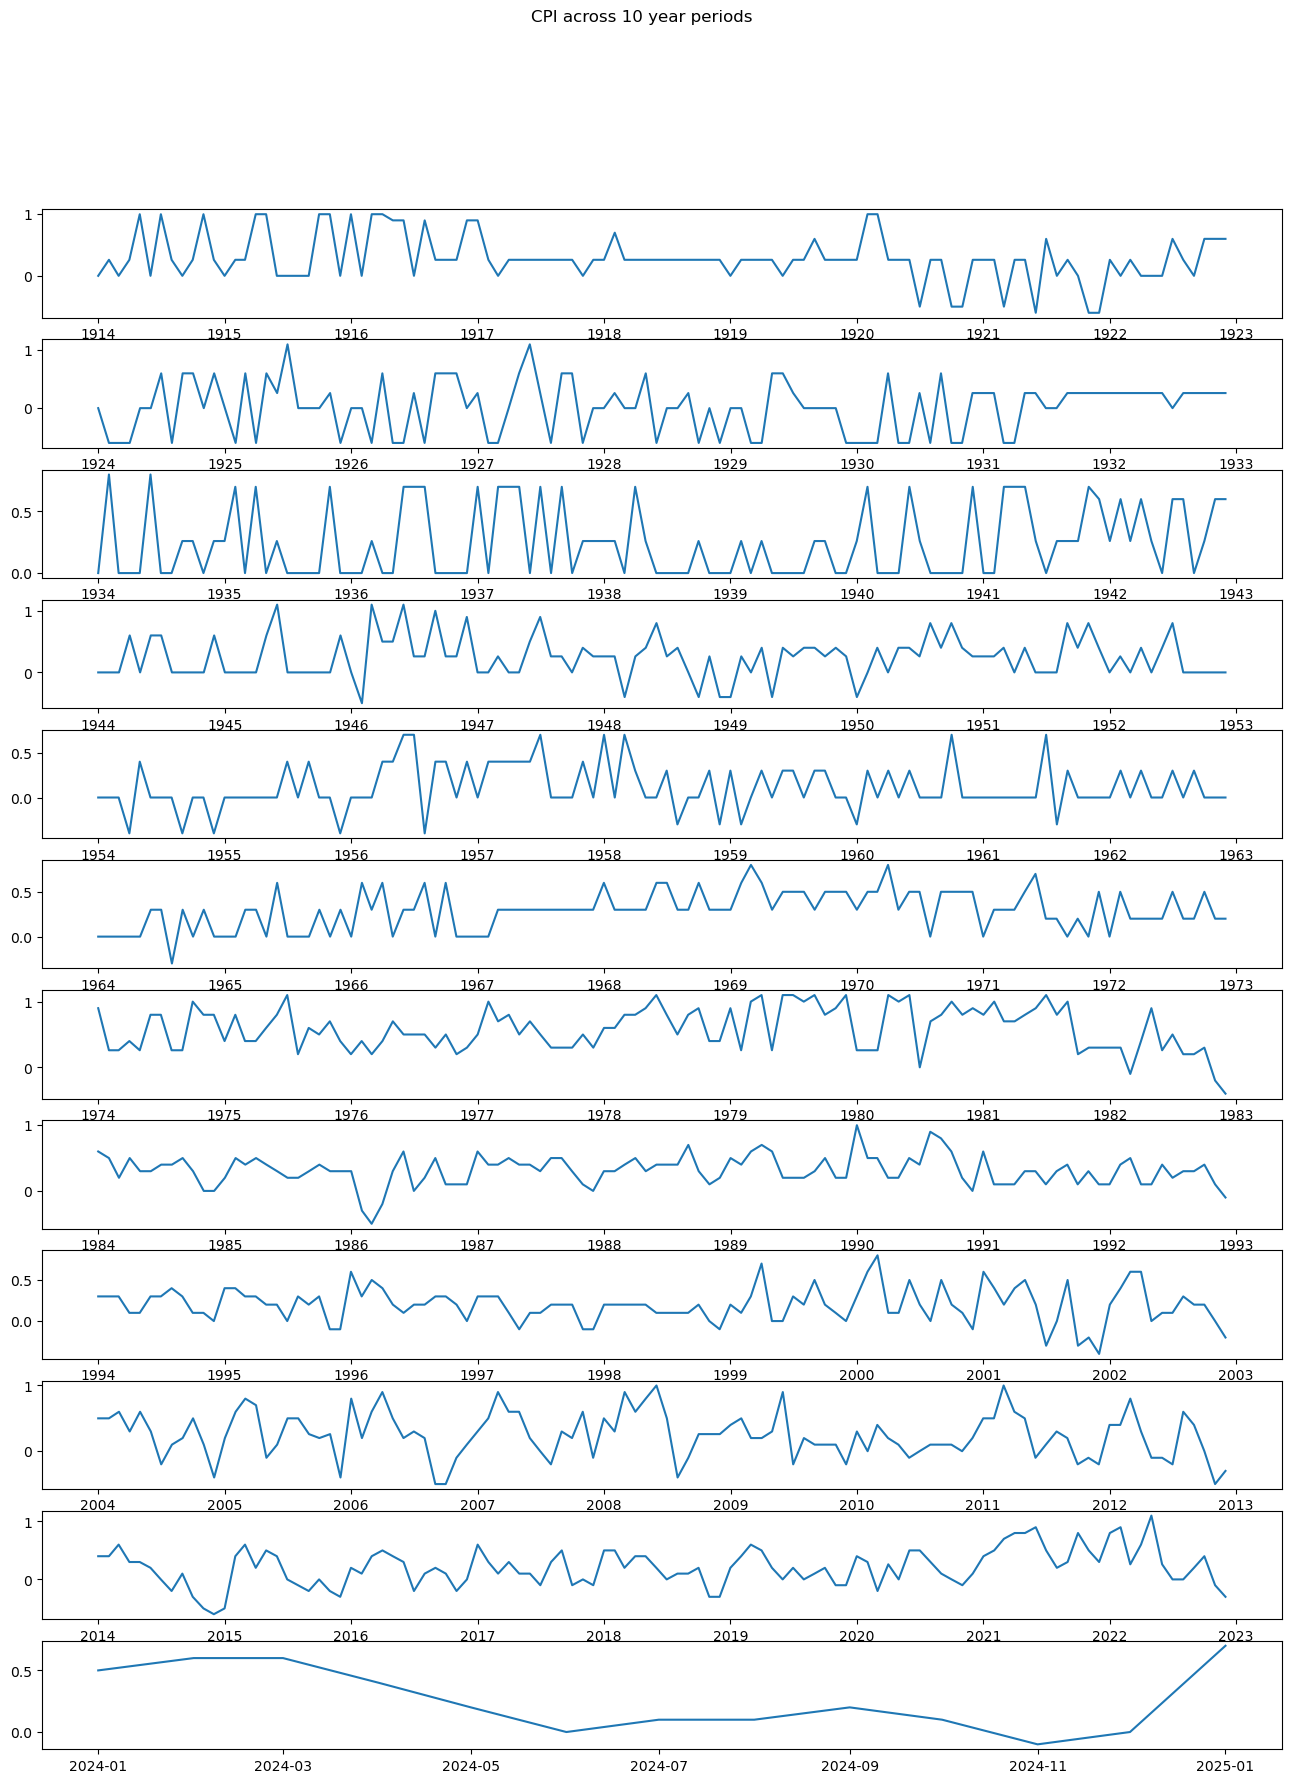

In [14]:

from pandas.tseries.offsets import YearEnd
plt.rc("figure",figsize=(16,20))
year = df.index.year.min()

fig, axs = plt.subplots((df.index.year.max() - df.index.year.min())//10 + 1)
fig.suptitle('CPI across 10 year periods')
count = 0

while year in df.index.year:
  df_temp = df[(df.index.year > year) & (df.index.year < year+10)]
  axs[count].plot(df_temp.index,df_temp.CPI)
  year = year + 10
  count = count + 1

## DECOMPOSITION

In [15]:
# !pip install statsmodels

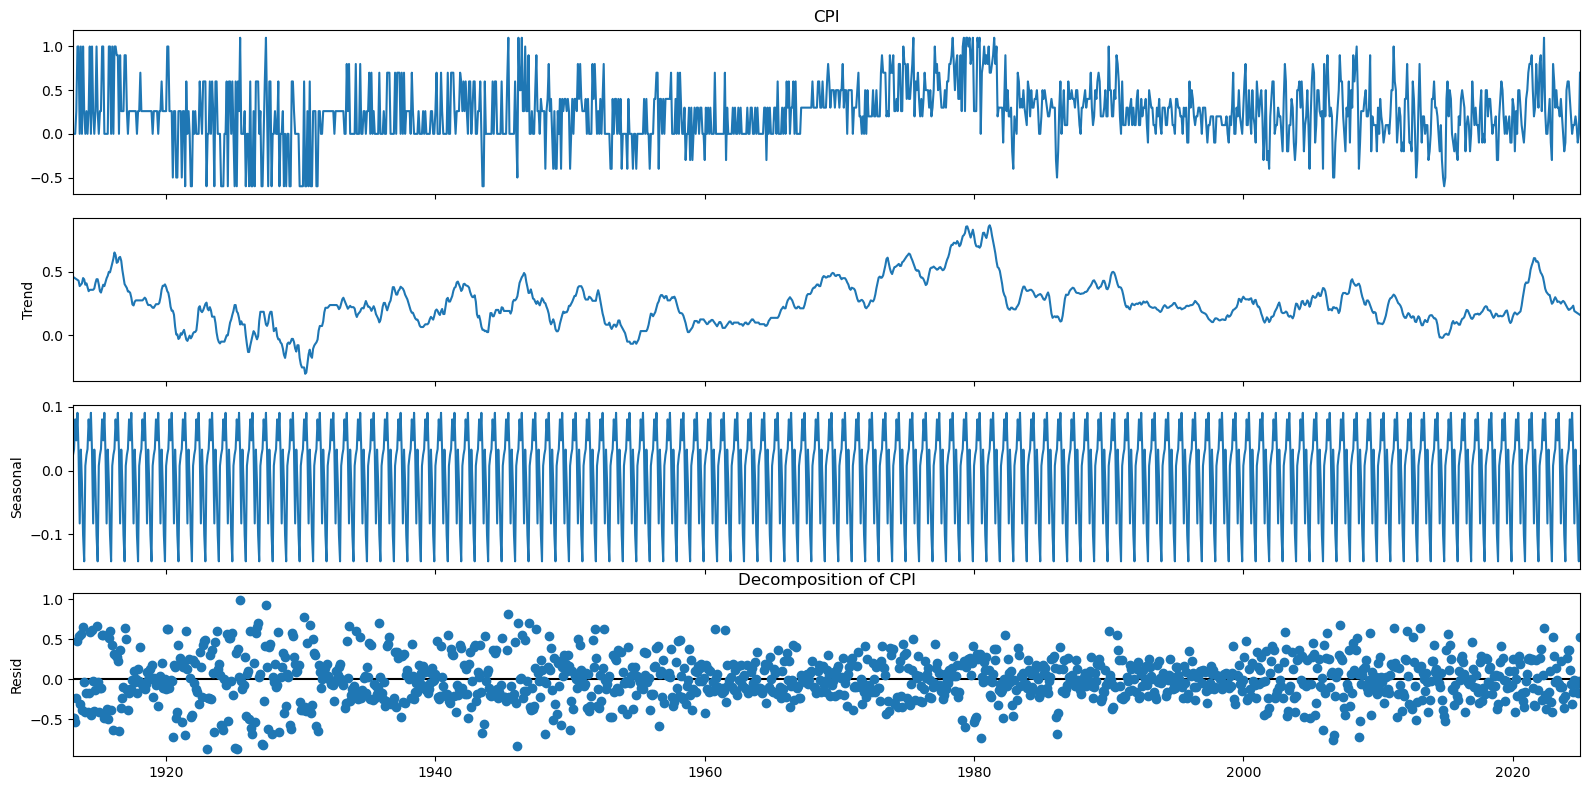

In [16]:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc("figure",figsize=(16,8))

def decompose(df, i):
  series = df.iloc[:,i]
  result = seasonal_decompose(series, model='additive',extrapolate_trend='freq',period=12)
  result.plot()
  plt.title('Decomposition of '+ df.columns.values.tolist()[i])
  plt.show()
  return result
result = decompose(df, 0)

## Stationarity

In [17]:

from statsmodels.tsa.stattools import adfuller

def ADF_Test(df,df_adf,i):	
	series = df.iloc[:,i]
	X = series.values
	result = adfuller(X)
	df_adf_i = pd.DataFrame({'Output':df.columns.values.tolist()[i],'ADF Statistic':result[0],'p-value':result[1],'CriticalValues':result[4]})
	df_adf = df_adf._append(df_adf_i,ignore_index = True)
	return df_adf

In [18]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df,df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-3.838417,0.002538,-3.435314
1,CPI,-3.838417,0.002538,-2.863732
2,CPI,-3.838417,0.002538,-2.567937


## Removing seasonality to make data stationary

In [19]:
df_nonseasonal = pd.DataFrame()

# Option 1: Use fillna
df_nonseasonal['CPI'] = df['CPI'] - df.shift(12)['CPI'].fillna(0)

# Option 2: Use replace with np.nan
# df_nonseasonal['CPI'] = df['CPI'] - df.shift(12).replace(np.nan, 0)['CPI']

df_nonseasonal.head()
     

,CPI
timestamp,
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,1.000000


In [20]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df_nonseasonal,df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-11.35136,9.976595e-21,-3.435314
1,CPI,-11.35136,9.976595e-21,-2.863732
2,CPI,-11.35136,9.976595e-21,-2.567937


## Subtracting Lags to make data stationary

In [21]:
# Option 1: Replace np.nan
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1).replace(np.nan, 0)['CPI']

# Option 2: Using fillna to replace NaN values with 0
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1)['CPI'].fillna(0)

df_nonseasonal.head()

,CPI,lag1
timestamp,,
1913-02-01,0.000000,0.000000
1913-03-01,0.000000,0.000000
1913-04-01,0.000000,0.000000
1913-05-01,0.260045,0.260045
1913-06-01,1.000000,0.739955


In [22]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(pd.DataFrame(df_nonseasonal['lag1']),df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,lag1,-11.113435,3.612137e-20,-3.435314
1,lag1,-11.113435,3.612137e-20,-2.863732
2,lag1,-11.113435,3.612137e-20,-2.567937


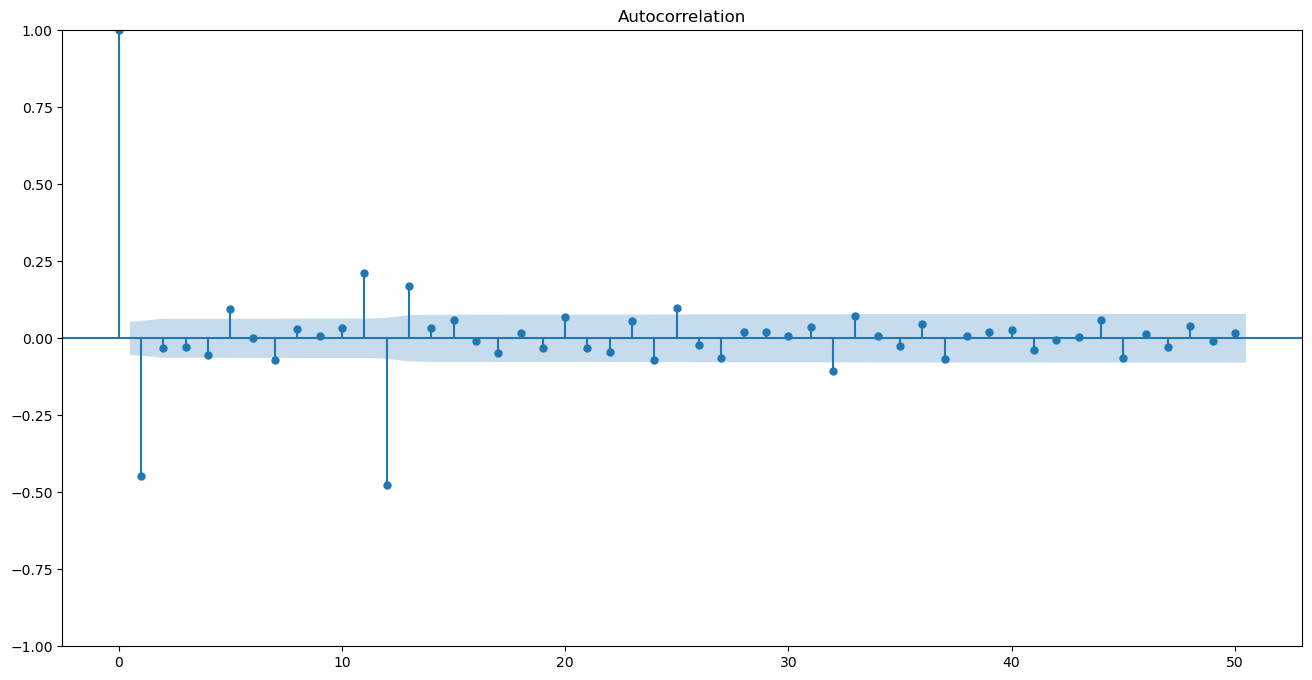

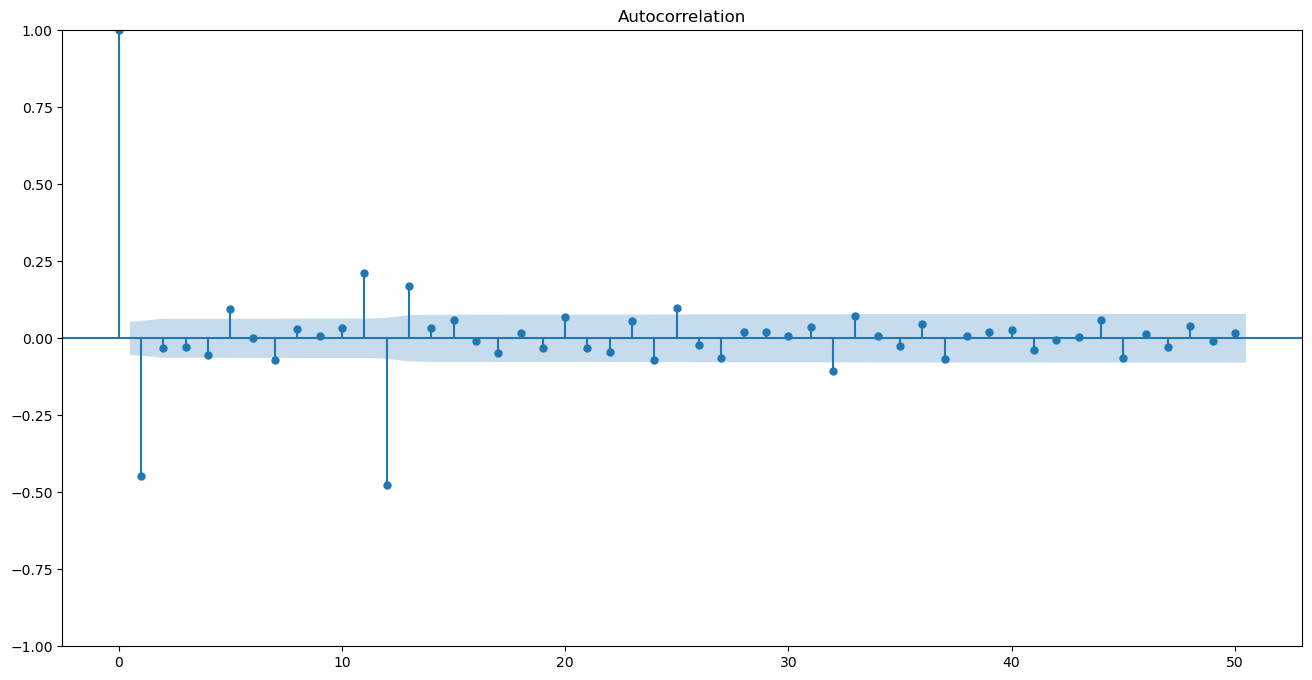

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_nonseasonal['lag1'],lags = 50)

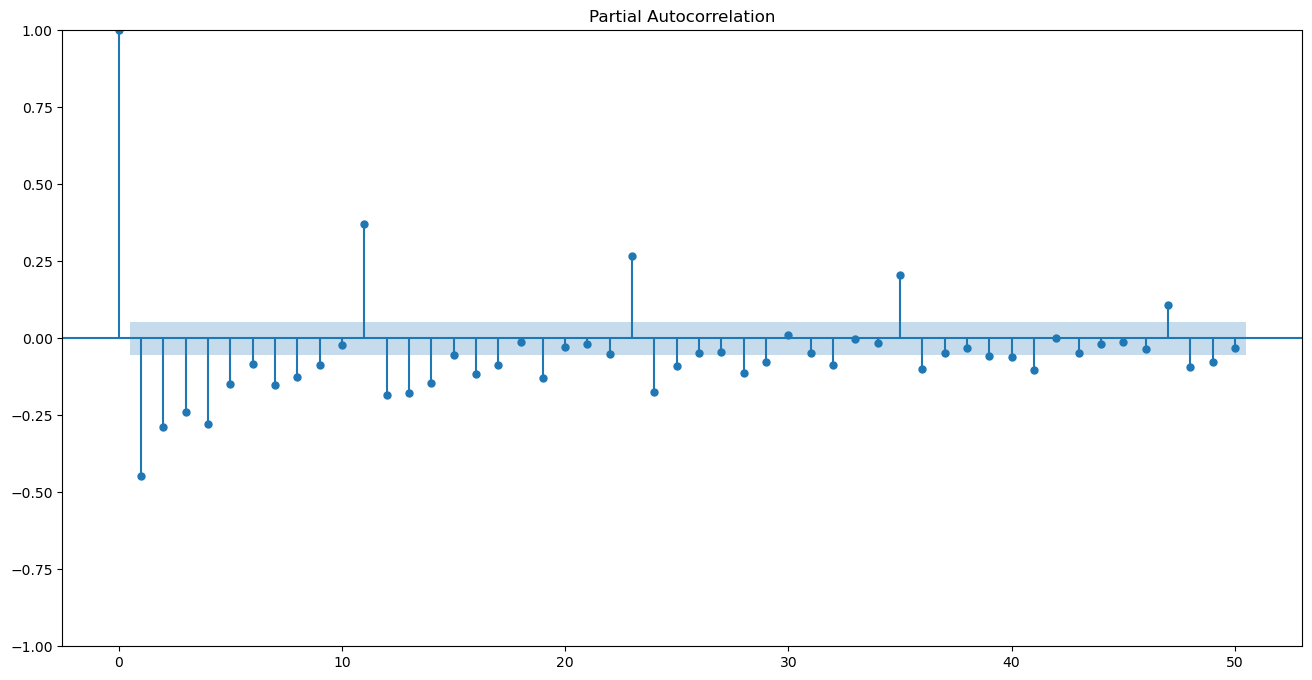

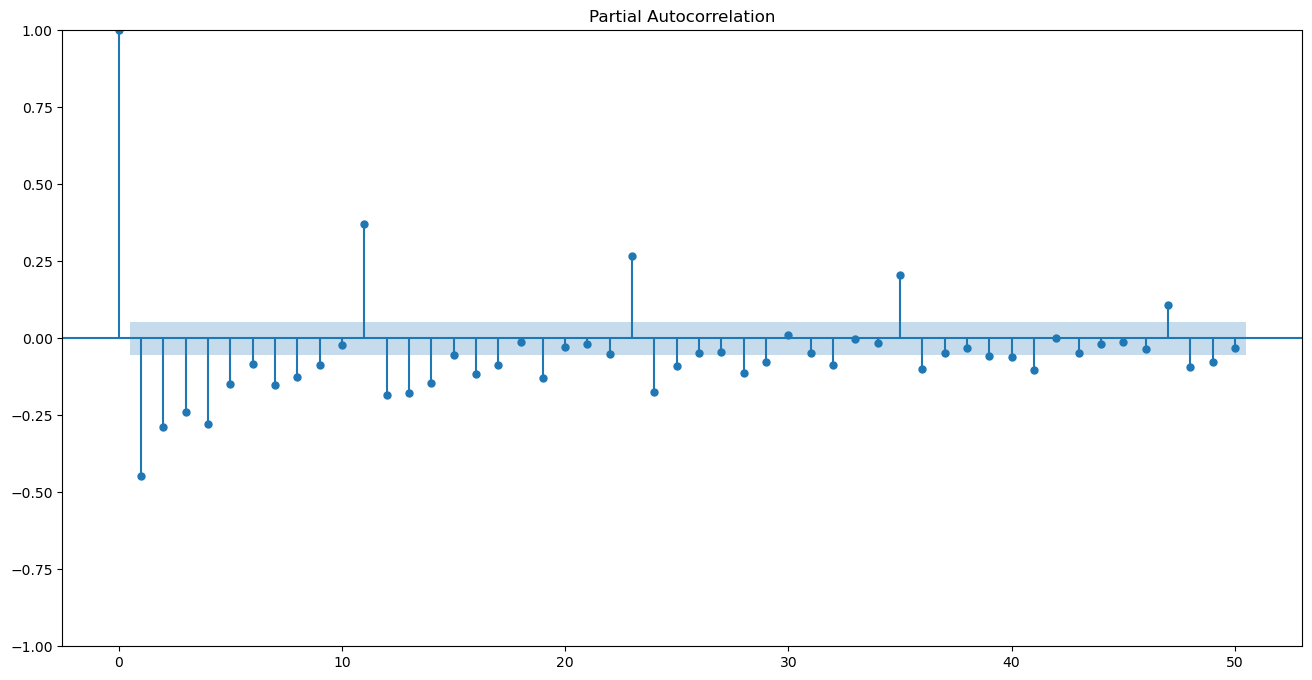

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_nonseasonal['lag1'],lags = 50)

## SARIMA model

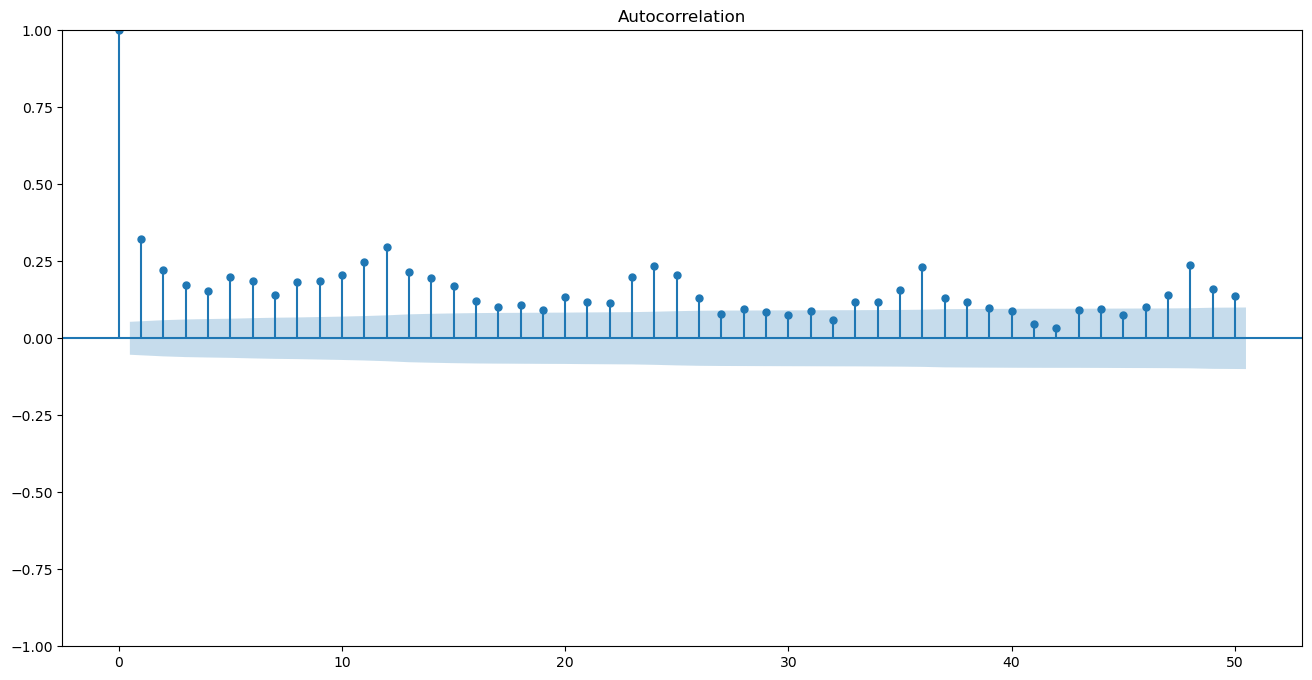

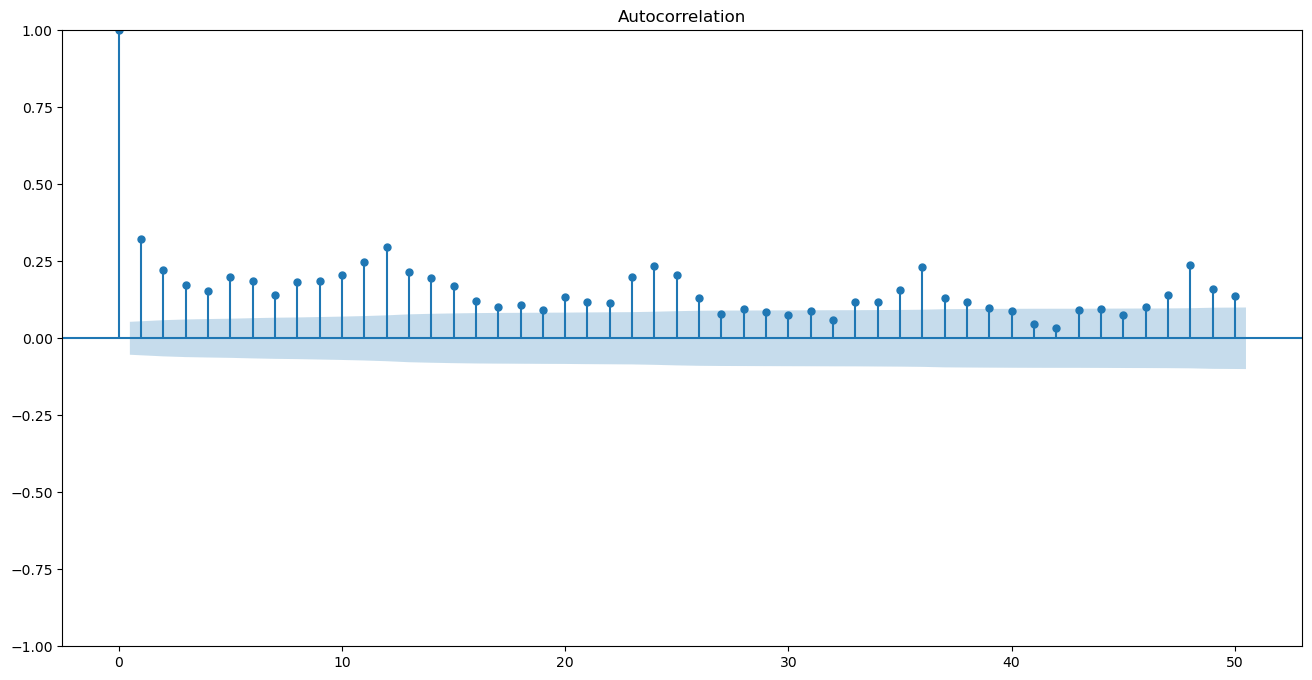

In [25]:

#autocorrelation plots for original data
plot_acf(df['CPI'],lags = 50)

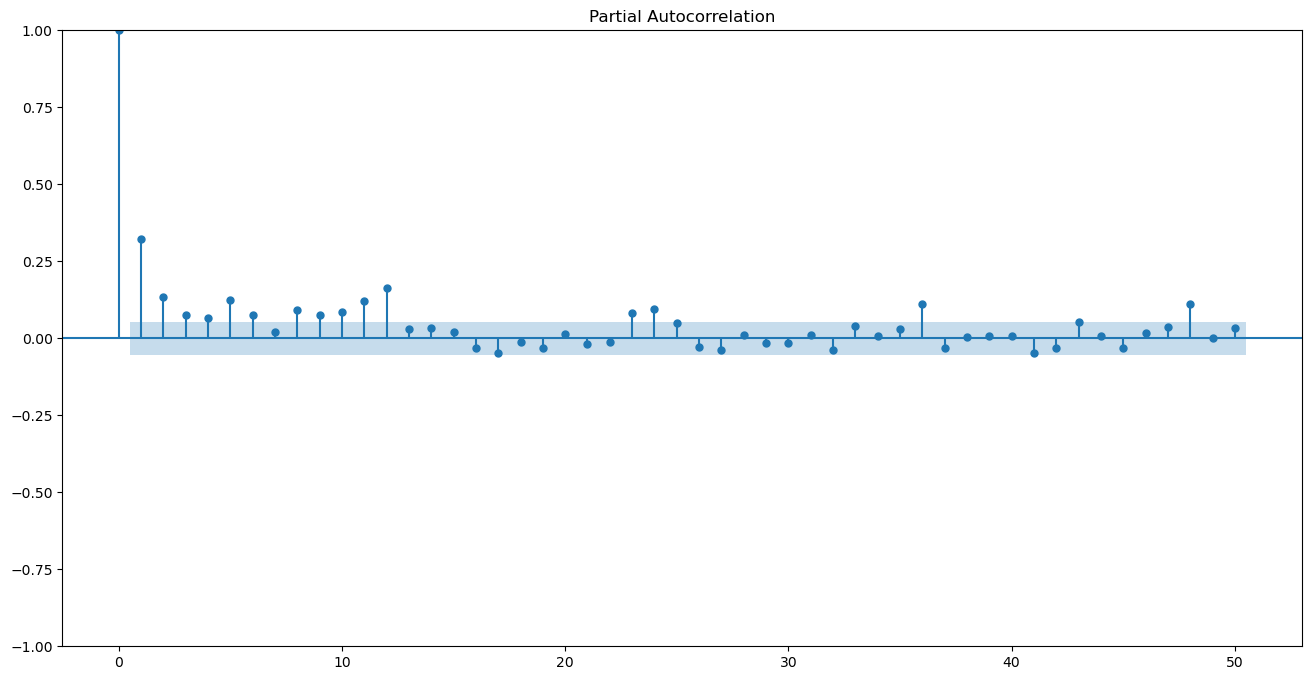

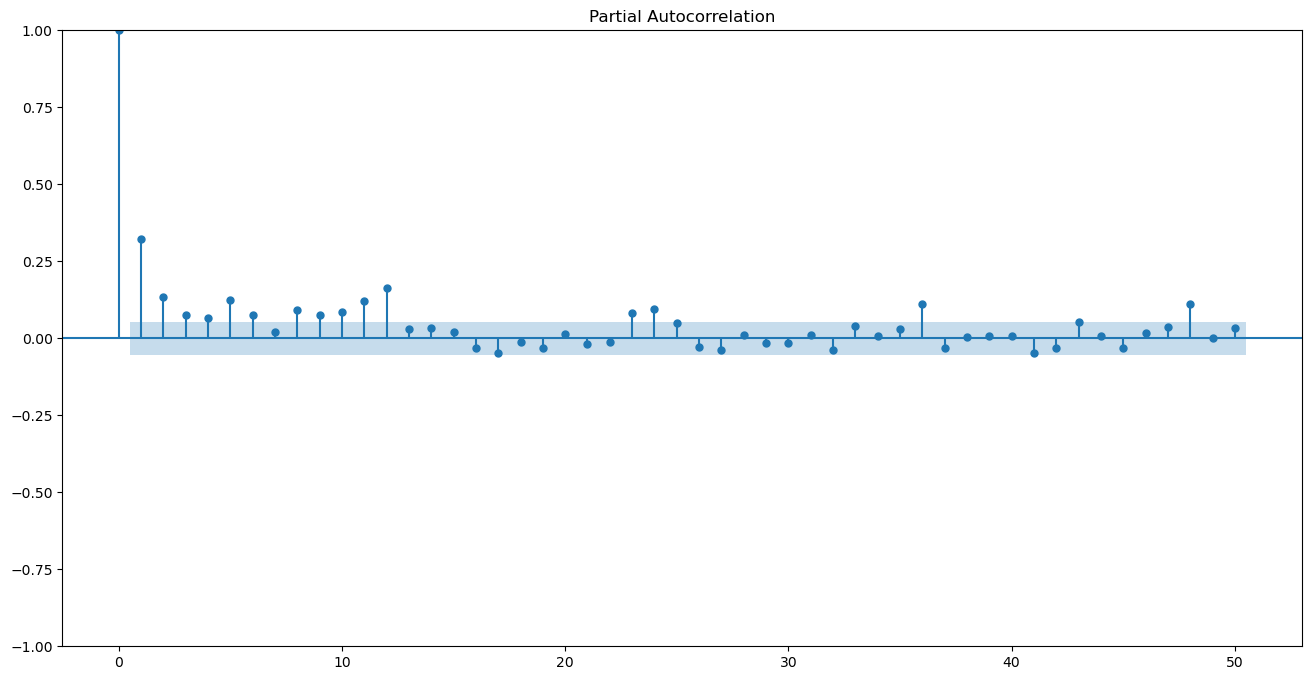

In [26]:
plot_pacf(df['CPI'],lags = 50)

## Train-Test Split

In [27]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_train = df.iloc[:int(0.9*df.shape[0]),:]
SARIMA_test = df.iloc[int(0.9*df.shape[0]):,:]
     

## Model

In [28]:
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

SARIMA_model = SARIMAX(SARIMA_train, order=my_order, seasonal_order=my_seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()
print(SARIMA_model_fit.summary())

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                 1209
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -303.032
Date:                            Sun, 02 Mar 2025   AIC                            612.064
Time:                                    12:53:24   BIC                            627.324
Sample:                                02-01-1913   HQIC                           617.813
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9068      0.012    -76.935      0.000      -0.930      -0.884
ma.S.L12      -0.9274      0.015   

## Predictions
### Predictions for training data

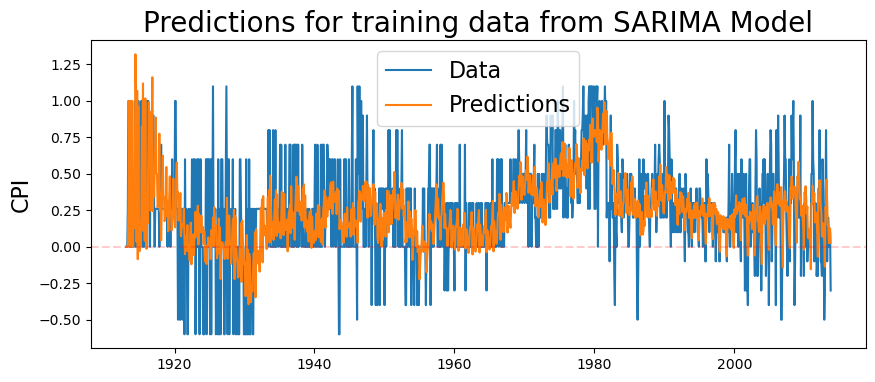

In [29]:

SARIMA_predictions = SARIMA_model_fit.predict(start = SARIMA_train.index[0], end = SARIMA_train.index[-1])
plt.figure(figsize=(10,4))
plt.plot(SARIMA_train)
plt.plot(SARIMA_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Predictions for training data from SARIMA Model', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

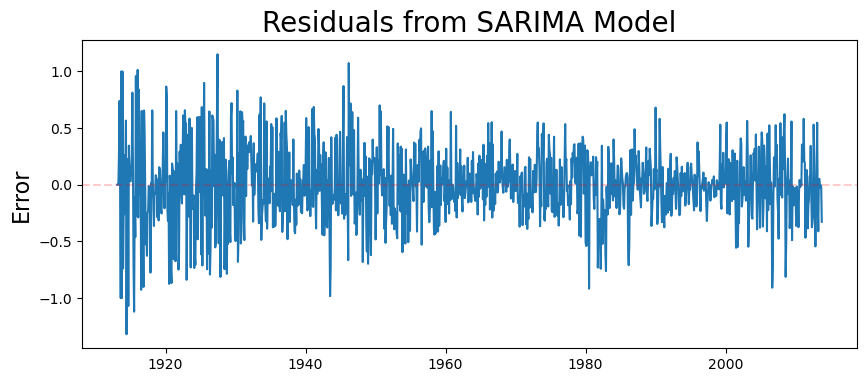

In [30]:

SARIMA_residuals = SARIMA_train['CPI'] - pd.DataFrame(SARIMA_predictions)['predicted_mean']
plt.figure(figsize=(10,4))
plt.plot(SARIMA_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [31]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals**2)))

Mean Absolute Error: 0.2415

Root Mean Squared Error: 0.32113802209933784


## Residual Analysis

In [32]:

#residuals analysis
residuals = [SARIMA_train.iloc[i,:]-SARIMA_predictions[i] for i in
range(len(SARIMA_predictions))]
residuals = pd.DataFrame(residuals)
residuals.head()

C:\Users\mkahs\AppData\Local\Temp\ipykernel_26928\957105244.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residuals = [SARIMA_train.iloc[i,:]-SARIMA_predictions[i] for i in


,CPI
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,0.739955


In [33]:

residuals.describe()

,CPI
count,1209.000000
mean,-0.001717
std,0.321266
min,-1.319897
25%,-0.181883
50%,-0.007485
75%,0.186836
max,1.151611


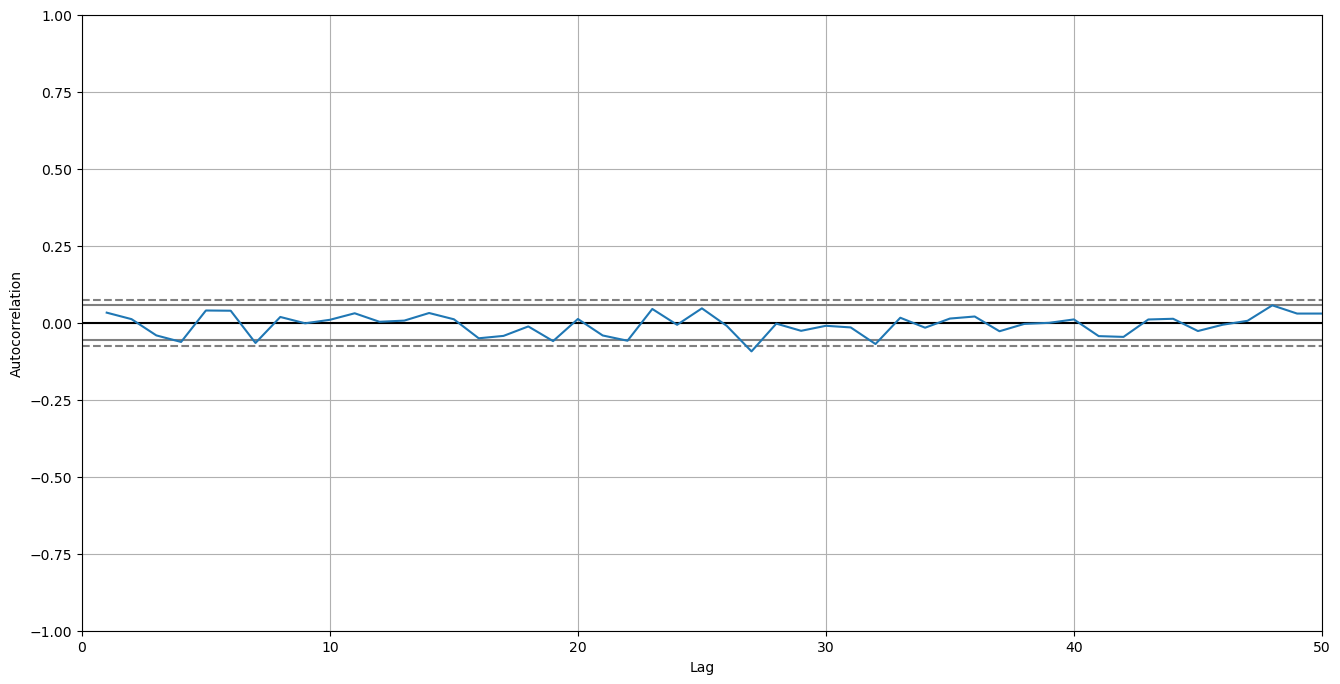

In [34]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(np.array(residuals))
ax.set_xlim([0, 50])
plt.show()

In [35]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(residuals,df_adf,0)
df_adf
#residuals are white noise, hence, the model has captured the collinearity well.

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-13.78486,9.152191e-26,-3.435802
1,CPI,-13.78486,9.152191e-26,-2.863948
2,CPI,-13.78486,9.152191e-26,-2.568052


In [36]:

SARIMA_predictions_test = SARIMA_model_fit.predict(start = SARIMA_test.index[0], end = SARIMA_test.index[-1])
SARIMA_residuals_test = SARIMA_test['CPI'] - pd.DataFrame(SARIMA_predictions_test)['predicted_mean']
     

Text(0, 0.5, 'CPI')

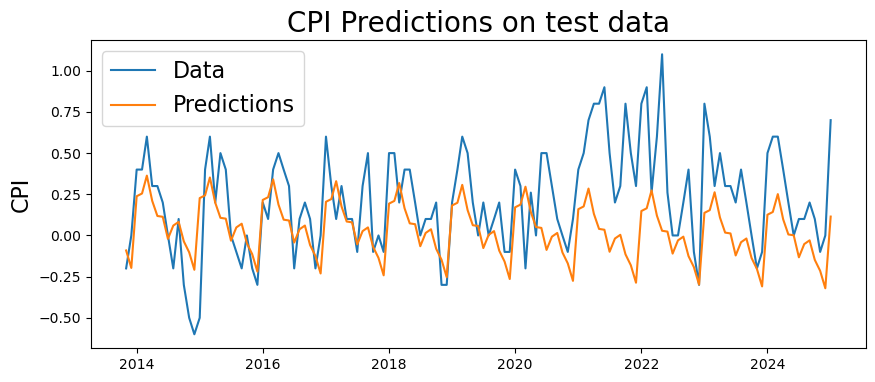

In [37]:

plt.figure(figsize=(10,4))

plt.plot(SARIMA_test)
plt.plot(SARIMA_predictions_test)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI Predictions on test data', fontsize=20)
plt.ylabel('CPI', fontsize=16)

In [38]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals_test)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals_test**2)))

Mean Absolute Error: 0.2488

Root Mean Squared Error: 0.3249987503501285


## Rolling Forecast Origin

In [39]:

from pandas.core.groupby.groupby import Timestamp
from dateutil.relativedelta import relativedelta
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

start_time = datetime(1960,1,1)
end_time = datetime(2016,6,1)

In [40]:

my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]

while roll_end_time+relativedelta(months=+1) in df.index:
  
  SARIMA_roll_test = df.loc[roll_end_time:roll_end_time+relativedelta(months=+0)]
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = SARIMA_roll_test.index[0], end = SARIMA_roll_test.index[-1])

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)

2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00
2017-07-01 00:00:00
2017-08-01 00:00:00
2017-09-01 00:00:00
2017-10-01 00:00:00
2017-11-01 00:00:00
2017-12-01 00:00:00
2018-01-01 00:00:00
2018-02-01 00:00:00
2018-03-01 00:00:00
2018-04-01 00:00:00
2018-05-01 00:00:00
2018-06-01 00:00:00
2018-07-01 00:00:00
2018-08-01 00:00:00
2018-09-01 00:00:00
2018-10-01 00:00:00
2018-11-01 00:00:00
2018-12-01 00:00:00
2019-01-01 00:00:00
2019-02-01 00:00:00
2019-03-01 00:00:00
2019-04-01 00:00:00
2019-05-01 00:00:00
2019-06-01 00:00:00
2019-07-01 00:00:00
2019-08-01 00:00:00
2019-09-01 00:00:00
2019-10-01 00:00:00
2019-11-01 00:00:00
2019-12-01 00:00:00
2020-01-01 00:00:00
2020-02-01 00:00:00
2020-03-01 00:00:00
2020-04-01 00:00:00
2020-05-01 00:00:00
2020-06-01 00:00:00
2020-07-01 00:00:00


Text(0, 0.5, 'CPI')

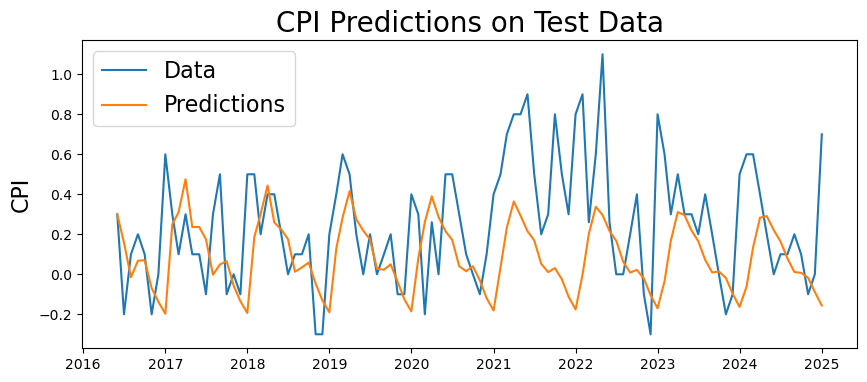

In [41]:

plt.figure(figsize=(10,4))

plt.plot(df.loc[end_time:])
plt.plot(SARIMA_roll_train.loc[end_time:])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI Predictions on Test Data', fontsize=20)
plt.ylabel('CPI', fontsize=16)

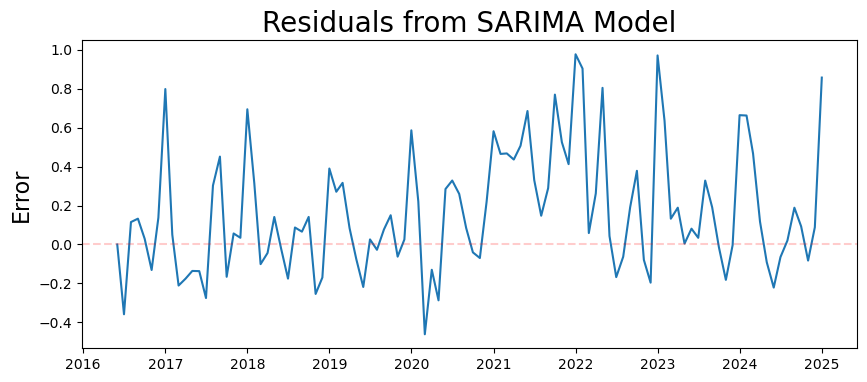

In [42]:

SARIMA_roll_residuals = df.loc[end_time:] - SARIMA_roll_train.loc[end_time:]
plt.figure(figsize=(10,4))
plt.plot(SARIMA_roll_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [43]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_roll_residuals['CPI'])),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_roll_residuals**2)))

Mean Absolute Error: 0.2568

Root Mean Squared Error: 0.35063141995713387


In [44]:

SARIMA_test.tail()

,CPI
timestamp,
2024-09-01,0.2
2024-10-01,0.1
2024-11-01,-0.1
2024-12-01,0.0
2025-01-01,0.7


## Forecasting

In [51]:

#consider entire dataset as training data for estimating forecasts for next 6 months
start_time = datetime(1913,1,1)
end_time = datetime(2025,1,1)

In [52]:

#obtain time series forecasts for the next 6 months
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]
c = 0
while c <= 5:
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = roll_end_time, end = roll_end_time+relativedelta(months=+0))

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)
  c += 1

2025-01-01 00:00:00
2025-02-01 00:00:00
2025-03-01 00:00:00
2025-04-01 00:00:00
2025-05-01 00:00:00
2025-06-01 00:00:00


In [53]:

time = []
roll_end_time = end_time + relativedelta(months=+1)
for i in range(6):
  time.append(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)

Text(0, 0.5, 'CPI')

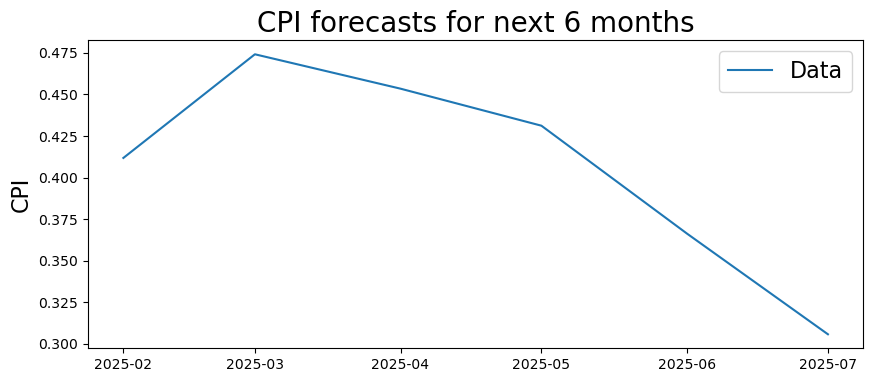

In [54]:

plt.figure(figsize=(10,4))

plt.plot(time, SARIMA_roll_train.loc[end_time+ relativedelta(months=+1):])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI forecasts for next 6 months', fontsize=20)
plt.ylabel('CPI', fontsize=16)
# plt.savefig('forecasts.png')

## HOLZ-WINTERS Train-Test Split (90%-10%) to match SARIMA

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_size = int(0.9 * df.shape[0])
HW_train = df.iloc[:train_size, :]
HW_test = df.iloc[train_size:, :]


## Fit the Holt-Winters Model

In [60]:
# Fit the Holt-Winters model (assuming additive trend & seasonality)
hw_model = ExponentialSmoothing(HW_train['CPI'], seasonal_periods=12, trend='add', seasonal='add')
hw_fit = hw_model.fit()

# Forecast for the length of the test set
hw_forecast = hw_fit.forecast(steps=len(HW_test))


## Compute Performance Metrics

In [62]:
# Calculate RMSE and MAE
hw_rmse = np.sqrt(mean_squared_error(HW_test['CPI'], hw_forecast))
hw_mae = mean_absolute_error(HW_test['CPI'], hw_forecast)

print("Holt-Winters Performance:")
print(f"RMSE: {hw_rmse:.4f}")
print(f"MAE: {hw_mae:.4f}")


Holt-Winters Performance:
RMSE: 0.2868
MAE: 0.2130


## Plot the Forecast vs Actual Data

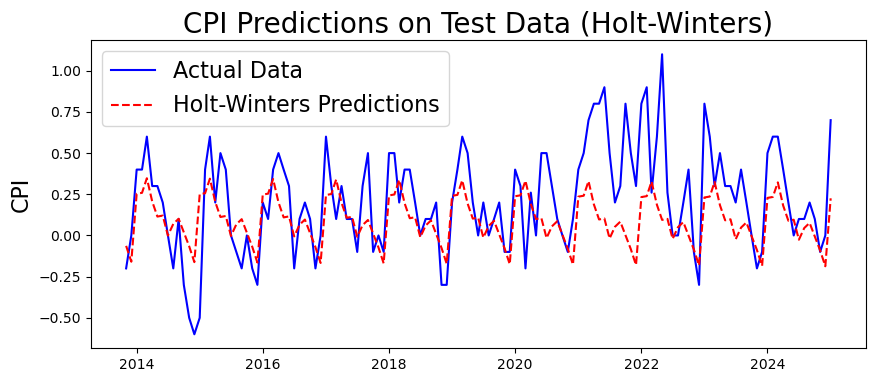

In [63]:
plt.figure(figsize=(10, 4))

plt.plot(HW_test.index, HW_test['CPI'], label='Actual Data', color='blue')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Predictions', linestyle='--', color='red')

plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data (Holt-Winters)', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()


## Overlay Holt-Winters with SARIMA

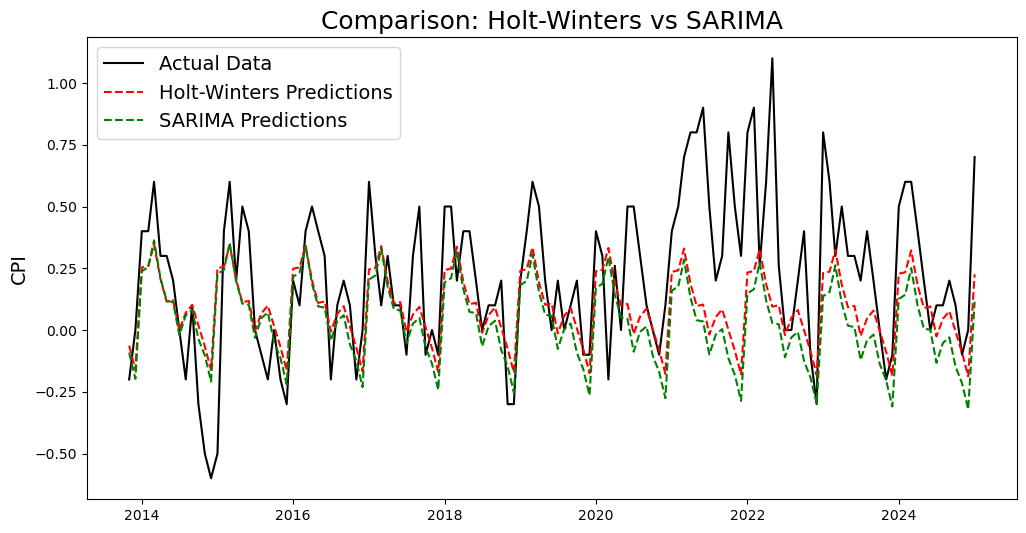

In [64]:
plt.figure(figsize=(12, 6))

plt.plot(HW_test.index, HW_test['CPI'], label='Actual Data', color='black')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Predictions', linestyle='--', color='red')
plt.plot(SARIMA_test.index, SARIMA_predictions_test, label='SARIMA Predictions', linestyle='--', color='green')

plt.legend(fontsize=14)
plt.title('Comparison: Holt-Winters vs SARIMA', fontsize=18)
plt.ylabel('CPI', fontsize=14)
plt.show()


In [70]:
df.columns

Index(['CPI'], dtype='object')

In [67]:
# !pip install prophet --user


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [79]:
# Read the Excel file (skipping the first 12 rows)
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)

# Create a 'Date' column using 'Year' and 'Period'
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01')

# Keep only rows where 'Period' starts with 'M'
df = df[df['Period'].str.startswith('M')]
df.rename(columns={'Value': 'CPI'}, inplace=True)
# Select only required columns for Prophet
df = df[['Date', 'CPI']].rename(columns={'Date': 'ds', 'CPI': 'y'})

# Sort by date
df = df.sort_values(by='ds')




In [95]:
# df.tail(20)

In [87]:
train_size = int(0.9 * df.shape[0])
prophet_train = df.iloc[:train_size]
prophet_test = df.iloc[train_size:]


In [88]:
# Step 1: Initialize and fit the Prophet model
prophet_model = Prophet(seasonality_mode='additive', yearly_seasonality=True)
prophet_model.fit(prophet_train)  # Ensure prophet_train is correctly defined

# Step 2: Create future DataFrame with the required forecast period
# future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')
# Generate future dates ensuring it covers the test period
future_dates = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='MS')  # 'MS' ensures month start


# Step 3: Generate forecast using Prophet
forecast = prophet_model.predict(future_dates)

# Step 4: Extract required columns from forecast
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')

# Step 5: Ensure it aligns with the test set
prophet_test = prophet_test.set_index('ds')  # Ensure test data uses datetime index
prophet_forecast = prophet_forecast.loc[prophet_test.index]  # Align forecasts to test data


13:55:47 - cmdstanpy - INFO - Chain [1] start processing
13:55:47 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
print("Forecast Index Range:", forecast.index.min(), "to", forecast.index.max())
print("Test Data Index Range:", prophet_test.index.min(), "to", prophet_test.index.max())

# Print a sample to check if dates match
print(forecast.index[-10:])  # Last 10 forecasted dates
print(prophet_test.index[:10])  # First 10 test dataset dates



Forecast Index Range: 0 to 1343
Test Data Index Range: 2013-11-01 00:00:00 to 2025-01-01 00:00:00
RangeIndex(start=1334, stop=1344, step=1)
DatetimeIndex(['2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01',
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01'],
              dtype='datetime64[ns]', name='ds', freq=None)


In [90]:
# Calculate RMSE and MAE
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])

print("Facebook Prophet Performance:")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")



Facebook Prophet Performance:
RMSE: 0.3916
MAE: 0.2933


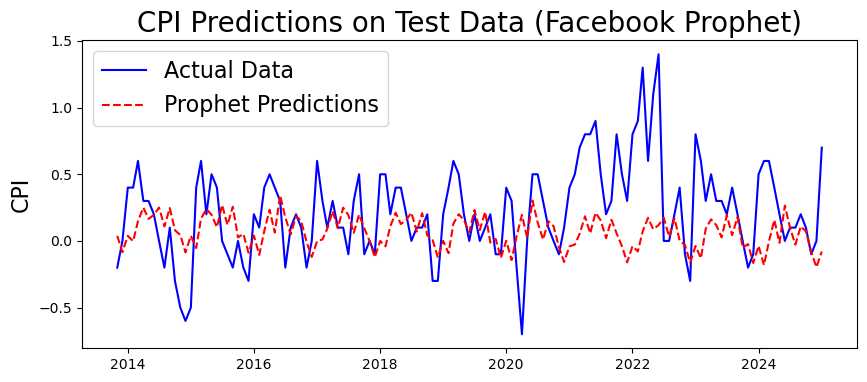

In [92]:
plt.figure(figsize=(10, 4))

# Use the index for the x-axis instead of prophet_test['ds']
plt.plot(prophet_test.index, prophet_test['y'], label='Actual Data', color='blue')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Predictions', linestyle='--', color='red')

plt.legend(fontsize=16)
plt.title('CPI Predictions on Test Data (Facebook Prophet)', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()


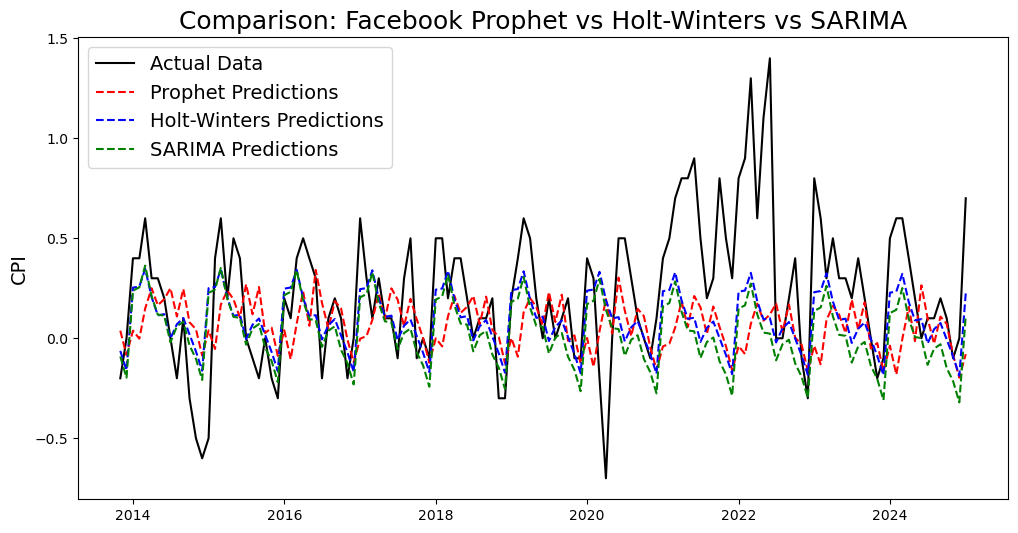

In [94]:
plt.figure(figsize=(12, 6))

# Use the index for prophet_test instead of prophet_test['ds']
plt.plot(prophet_test.index, prophet_test['y'], label='Actual Data', color='black')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Predictions', linestyle='--', color='red')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Predictions', linestyle='--', color='blue')
plt.plot(SARIMA_test.index, SARIMA_predictions_test, label='SARIMA Predictions', linestyle='--', color='green')

plt.legend(fontsize=14)
plt.title('Comparison: Facebook Prophet vs Holt-Winters vs SARIMA', fontsize=18)
plt.ylabel('CPI', fontsize=14)
plt.show()
